In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Study/NLP/밑딥2/deep-learning-from-scratch-2

/content/drive/MyDrive/Study/NLP/밑딥2/deep-learning-from-scratch-2


In [ ]:
!ls

ch01  ch03  ch05  ch07	common	   dataset			LICENSE.md
ch02  ch04  ch06  ch08	cover.png  equations_and_figures_2.zip	README.md


# 6. 게이트가 추가된 RNN

* 장기의존 관계. (RNN X / LSTM GRU O : 게이트의 존재 )

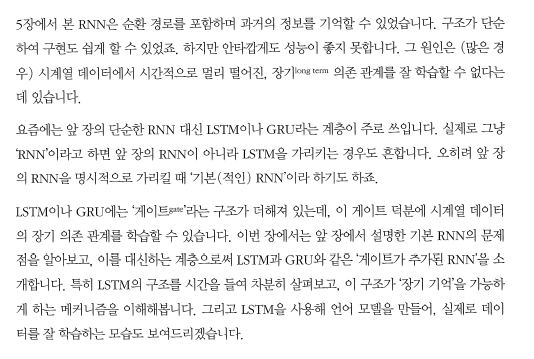

# 6.1 RNN의 문제점 : 장기 기억의 어려움

## 6.1.1 RNN 복습

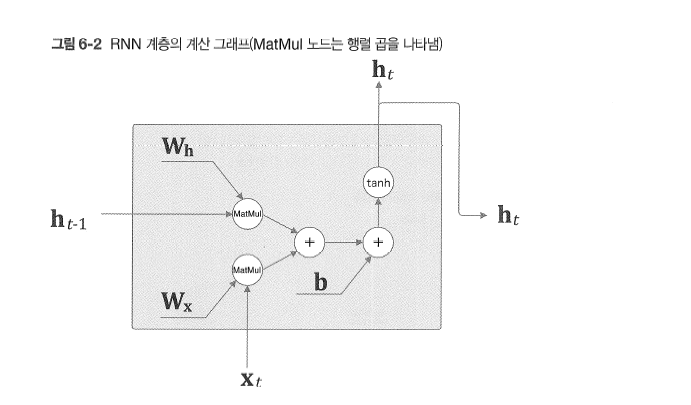

## 6.1.2 기울기 손실 또는 기울기 폭발

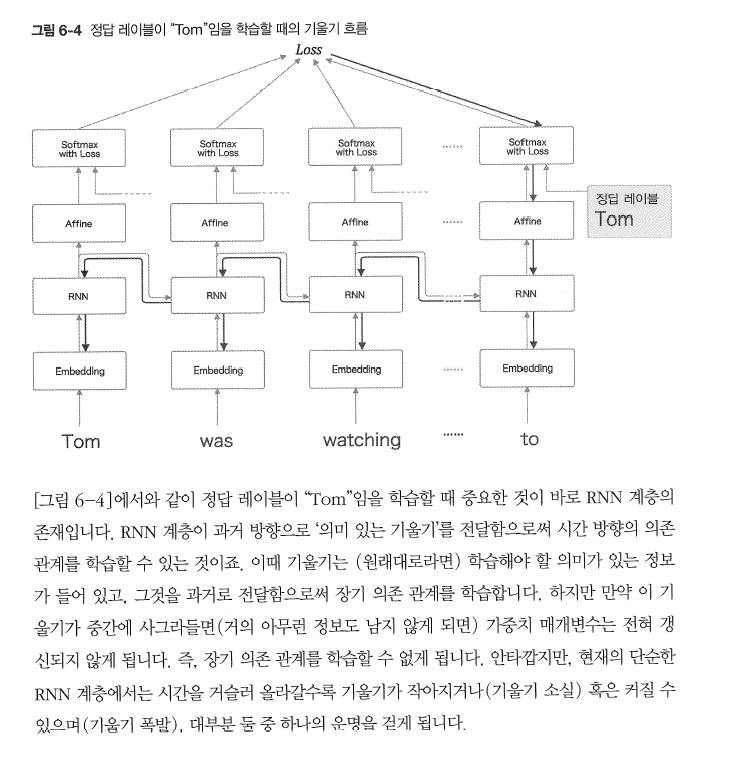

## 6.1.3 기울기 소실과 기울기 폭발의 원인

* 역전파할때
### 1. y=tanh(x)의 미분 -> 기울기 소실

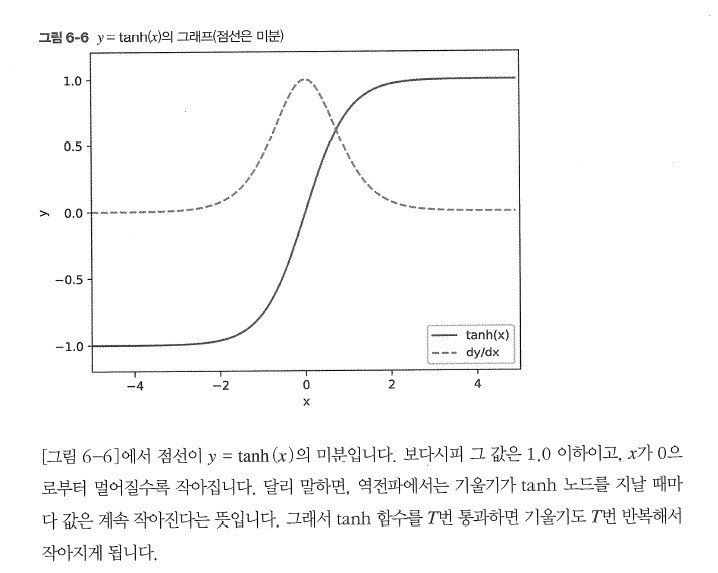

### 2. Matmul의 미분 -> 기울기 폭발

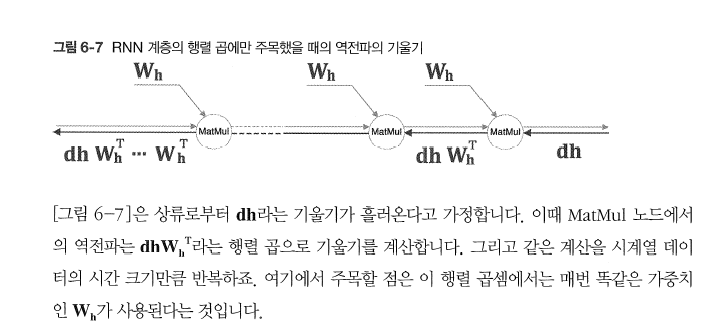

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


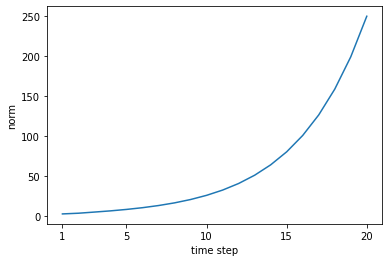

In [ ]:
# Matmul node 역전파시의 기울기의 크기 변화 관찰 : 기울기 폭발

import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H) # 기울기 폭발
# Wh = np.random.randn(H, H) * 0.5 # 기울기 소실

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # L2 norm
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

* 기울기 dh는 시간 크기에 비례하여 지수적으로 증가한다. (exploding gradients)
* -> 오버플로 -> NaN값 발생 -> 신경망 학습이 제대로 수행되지않음.

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


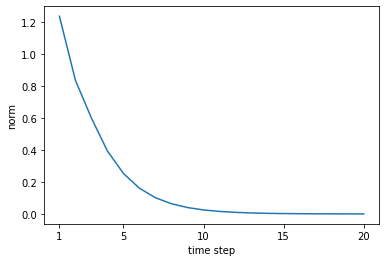

In [ ]:
# Matmul node 역전파시의 기울기의 크기 변화 관찰 : 기울기 소실

import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

# Wh = np.random.randn(H, H) # 기울기 폭발
Wh = np.random.randn(H, H) * 0.5 # 기울기 소실

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # L2 norm
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

* 기울기 소실이 일어나면 기울기가 매우 빠르게 작아진다. 그리고 기울기가 일정 수준 이하로 작아지면, 가중치 매개변수가 더 이상 갱신되지 않으므로, 장기 의존 관계를 학습할 수 없게 된다.

## 6.1.4 기울기 폭발 대책 : gradients clipping

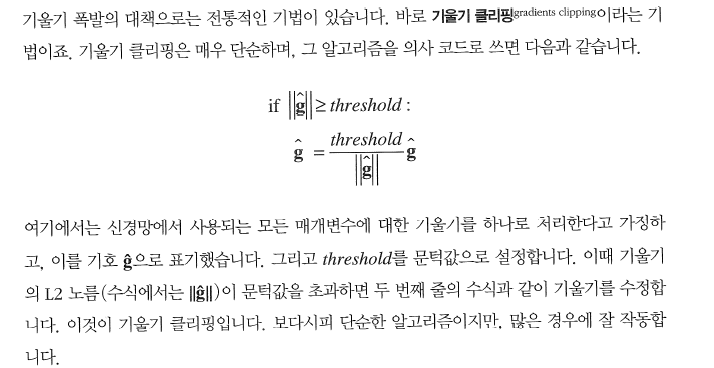

In [ ]:
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0 # threshold 값


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


# 6.2 기울기 소실 방지 LSTM ( 게이트가 추가된 RNN )


## 6.2.1 LSTM의 인터페이스

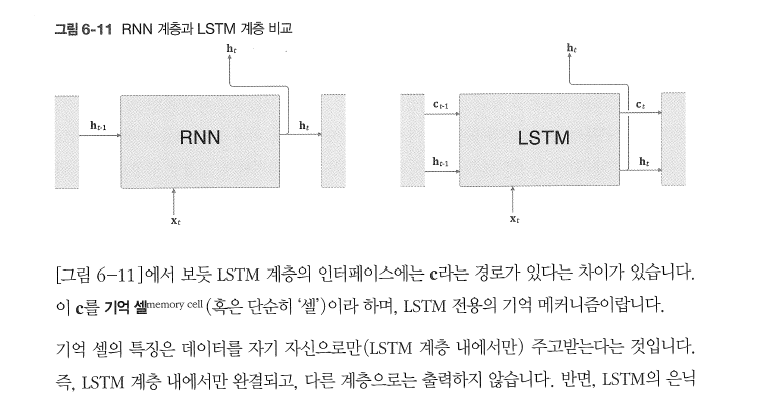

* c : memory cell, LSTM 전용의 기억 메커니즘
- 외부에서 보이지않으므로, 존재 자체를 생각할 필요가 없음.

## 6.2.2 LSTM 계층 조립하기

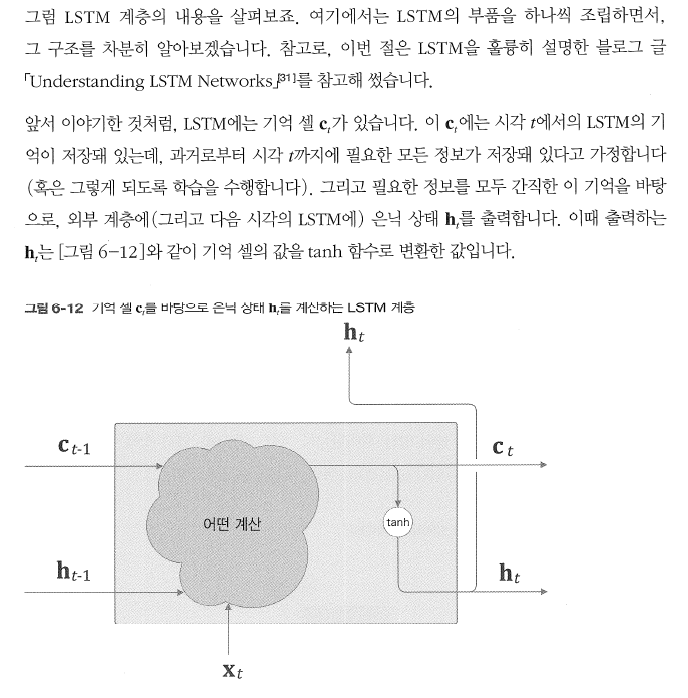

* h(t) = tanh(c(t)) : c(t)의 각 요소에 tanh 함수를 적용한다는 뜻이다.

* Gate : 데이터의 흐름을 제어. 
- 어느정도? (openness) : 0.0 ~ 1.0
- 게이트의 openness 또한 데이터로부터 자동으로 학습된다.

## 6.2.3 output 게이트

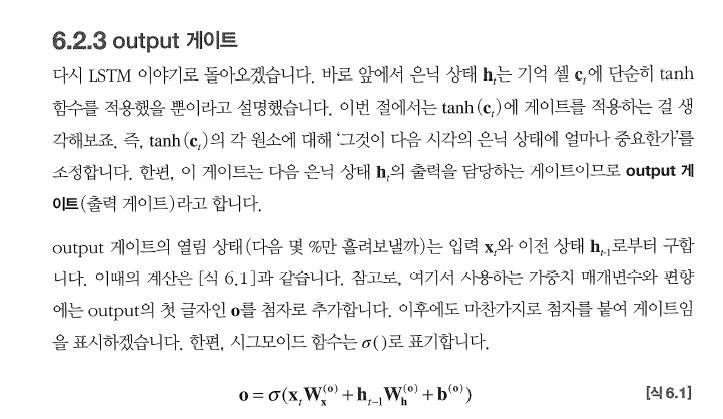

1.   항목 추가
2.   항목 추가



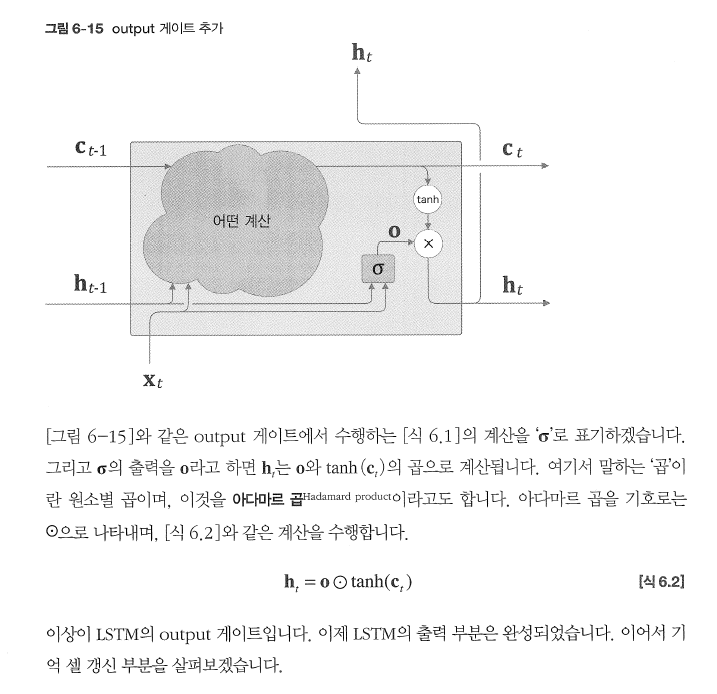

## 6.2.4 forget 게이트

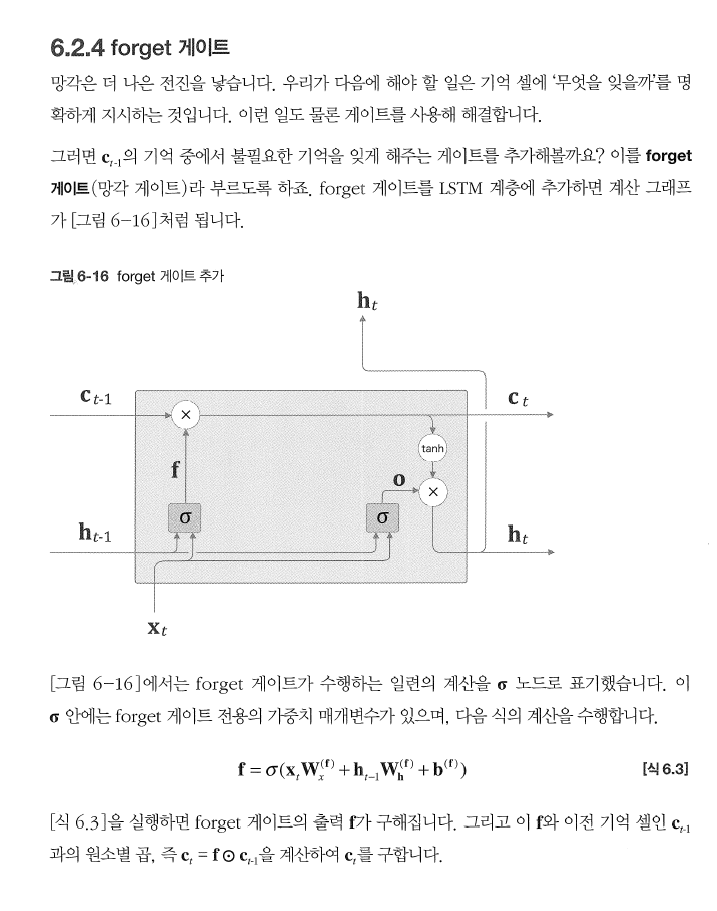

## 6.2.5 새로운 기억 셀

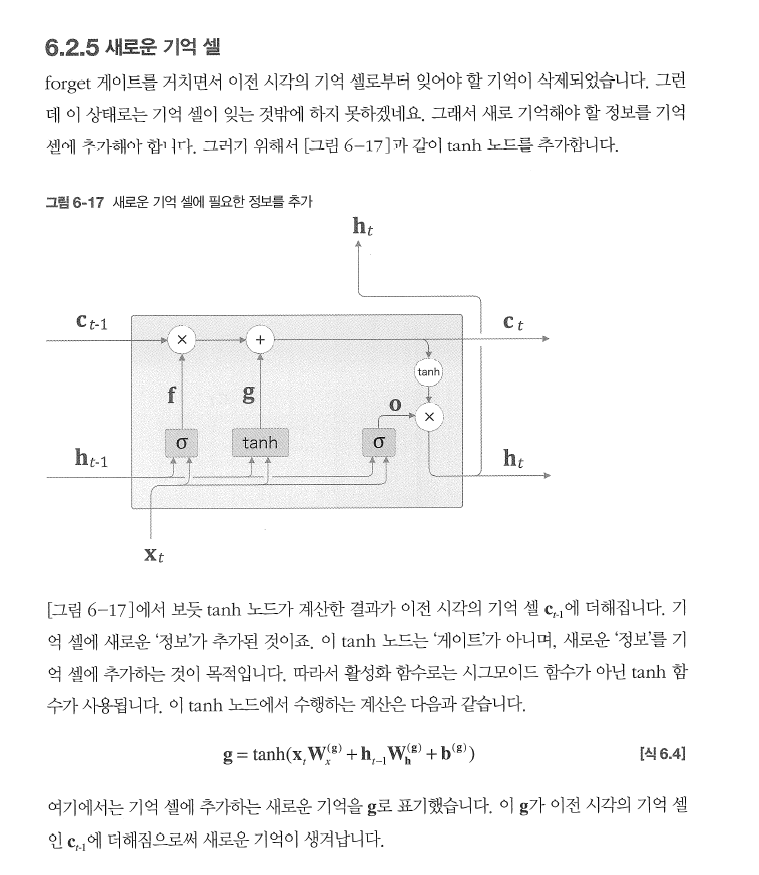

## 6.2.6 input 게이트

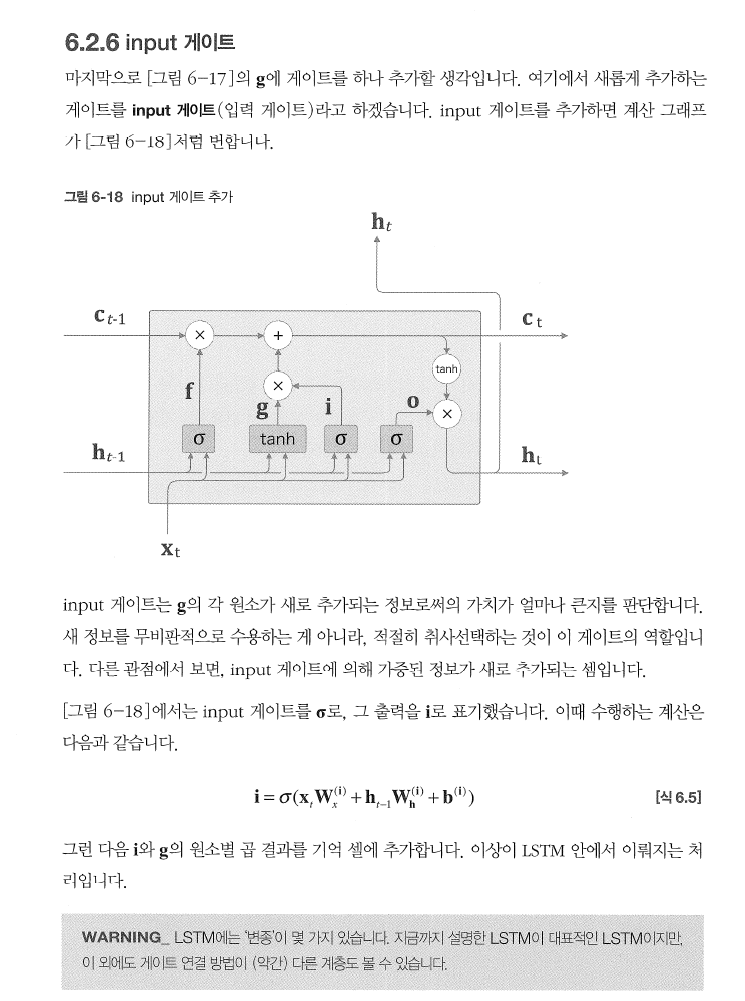

## 6.2.7 LSTM의 기울기 흐름 : memory cell과 게이트의 기울기 소실 방지

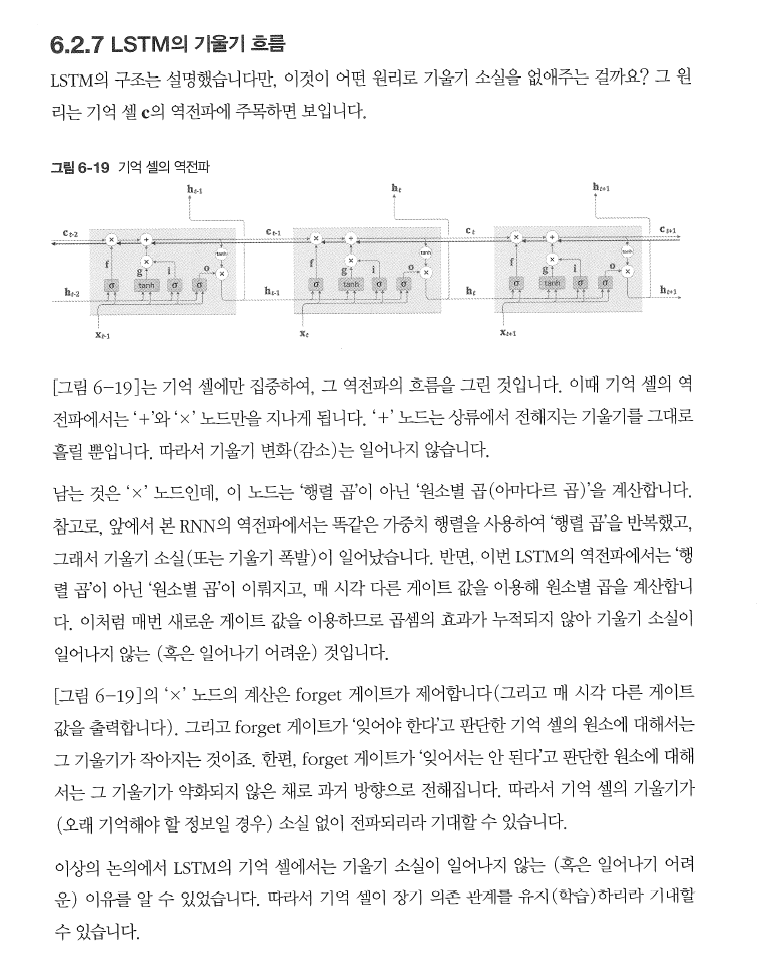

-> 기억셀이 장기 의존 관계를 학습하리라 기대할 수 있음.
(Long Short-Term Memory)

# 6.3 LSTM 구현

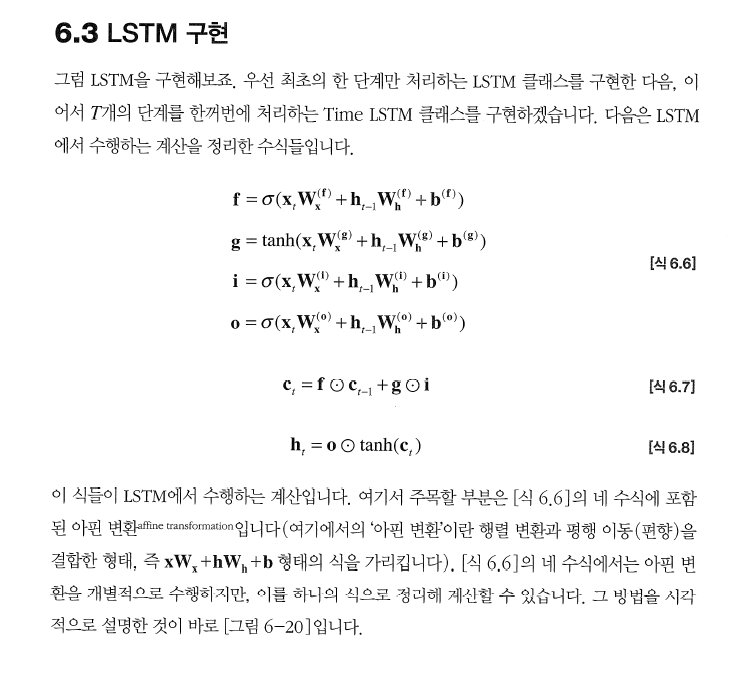

* f = forget
* g = 새로운 기억 셀
* i = input
* o = output

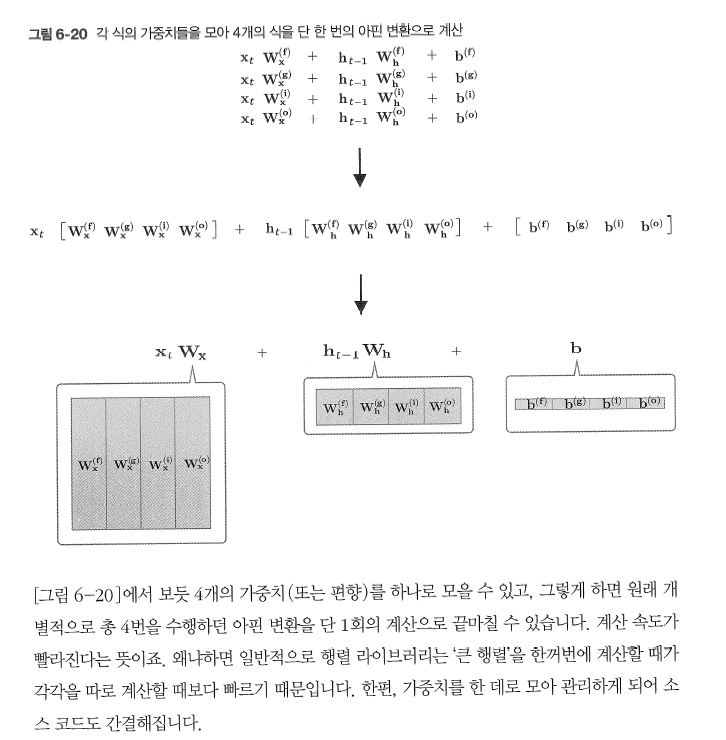

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None # 순전파때 중간 결과를 보관했다가 역전파 계산에 사용하려는 용도의 인스턴스 변수.

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b # Affine Transformation

        # 모아놓은 가중치를 slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)  # 역전파 계산에 사용
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do)) # slice 노드의 역전파. 인수로 주어진 배열들을 가로로 연결.

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

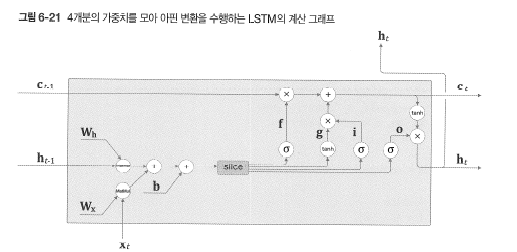

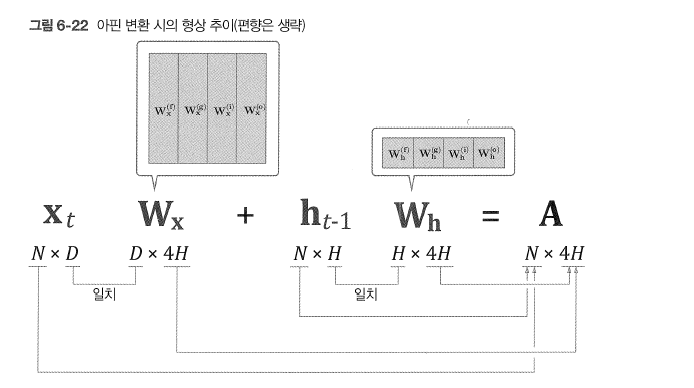

## 6.3.1 Time LSTM 구현

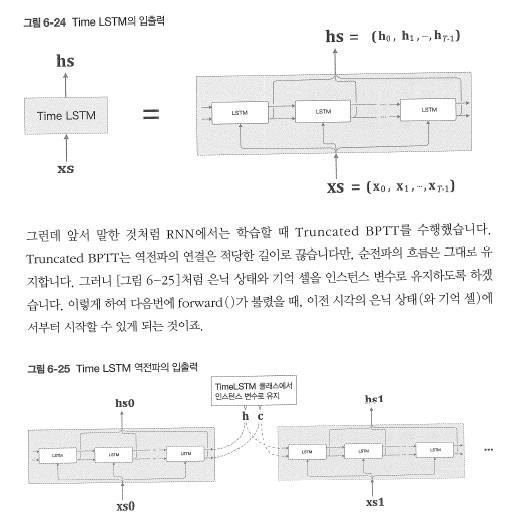

In [ ]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None: # Truncated Time LSTM 간 데이터 이동
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None: # Truncated Time LSTM 간 데이터 이동
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

# 6.4 LSTM을 사용한 언어모델

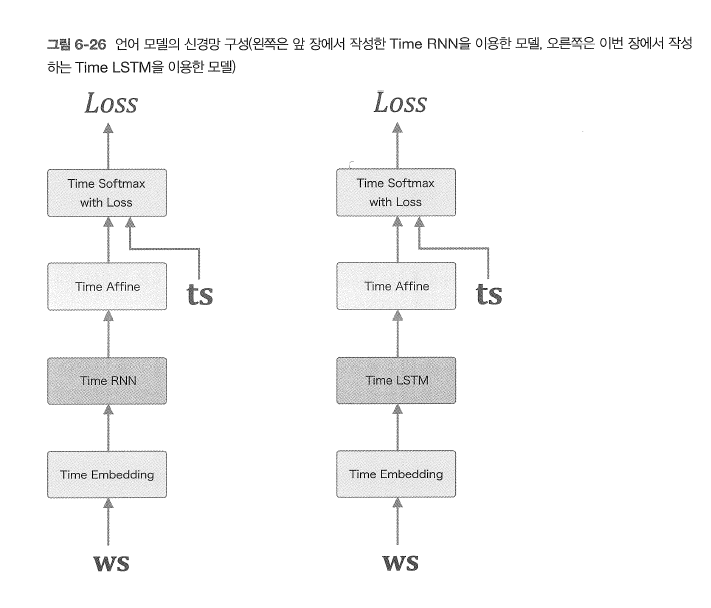

In [ ]:
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs): # softmax 계층 직전까지 처리
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self,file_name='Rnnlm.pkl'):
      with open(file_name,'wb') as f:
        pickle.dump(self.params,f)

    def load_params(self,file_name='Rnnlm.pkl'):
      with open(file_name,'rb') as f:
        self.params=pickle.load(f)

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.64
| 에폭 1 |  반복 21 / 1327 | 시간 7[s] | 퍼플렉서티 3122.83
| 에폭 1 |  반복 41 / 1327 | 시간 14[s] | 퍼플렉서티 1210.16
| 에폭 1 |  반복 61 / 1327 | 시간 21[s] | 퍼플렉서티 967.45
| 에폭 1 |  반복 81 / 1327 | 시간 28[s] | 퍼플렉서티 798.75
| 에폭 1 |  반복 101 / 1327 | 시간 35[s] | 퍼플렉서티 655.06
| 에폭 1 |  반복 121 / 1327 | 시간 42[s] | 퍼플렉서티 627.23
| 에폭 1 |  반복 141 / 1327 | 시간 49[s] | 퍼플렉서티 599.71
| 에폭 1 |  반복 161 / 1327 | 시간 56[s] | 퍼플렉서티 592.13
| 에폭 1 |  반복 181 / 1327 | 시간 64[s] | 퍼플렉서티 592.73
| 에폭 1 |  반복 201 / 1327 | 시간 70[s] | 퍼플렉서티 507.61
| 에폭 1 |  반복 221 / 1327 | 시간 77[s] | 퍼플렉서티 492.27
| 에폭 1 |  반복 241 / 1327 | 시간 84[s] | 퍼플렉서티 446.70
| 에폭 1 |  반복 261 / 1327 | 시간 91[s] | 퍼플렉서티 467.51
| 에폭 1 |  반복 281 / 1327 | 시간 98[s] | 퍼플렉서티 461.43
| 에폭 1 |  반복 301 / 1327 | 시간 105[s] | 퍼플렉서티 391.07
| 에폭 1 |  반복 321 / 1327 | 시간 112[s] | 퍼플렉서티 352.49
| 에폭 1 |  반복 341 / 1327 | 시간 119[s] | 퍼플렉서티 406.60
| 에폭 1 |  반복 361 / 1327 | 시간 126[s] | 퍼플렉서티 405.74
| 에폭 1 |  반복 381 / 1327 | 시간 133[s] | 퍼플렉서티 3

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

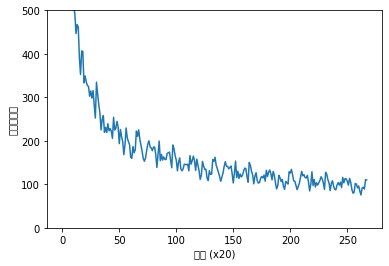

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.37618575484225


In [ ]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

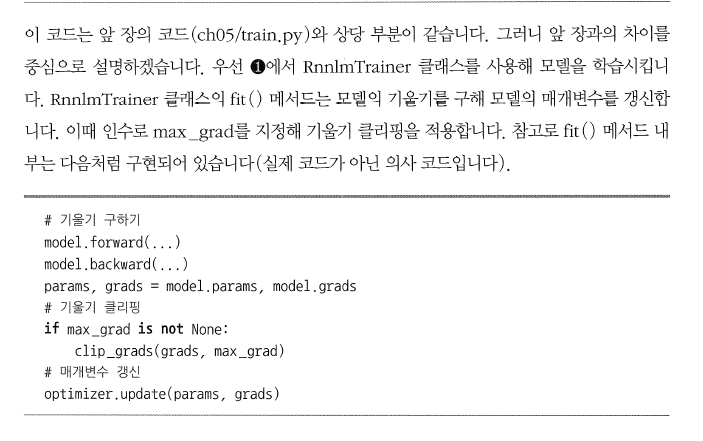

# 6.5 RNNLM 추가개선

## 6.5.1 LSTM 계층 다층화

## 6.5.2 드롭아웃에 의한 과적합 억제

* RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으키므로, 무작정 계층을 다층화한다고 좋은게 아니다.

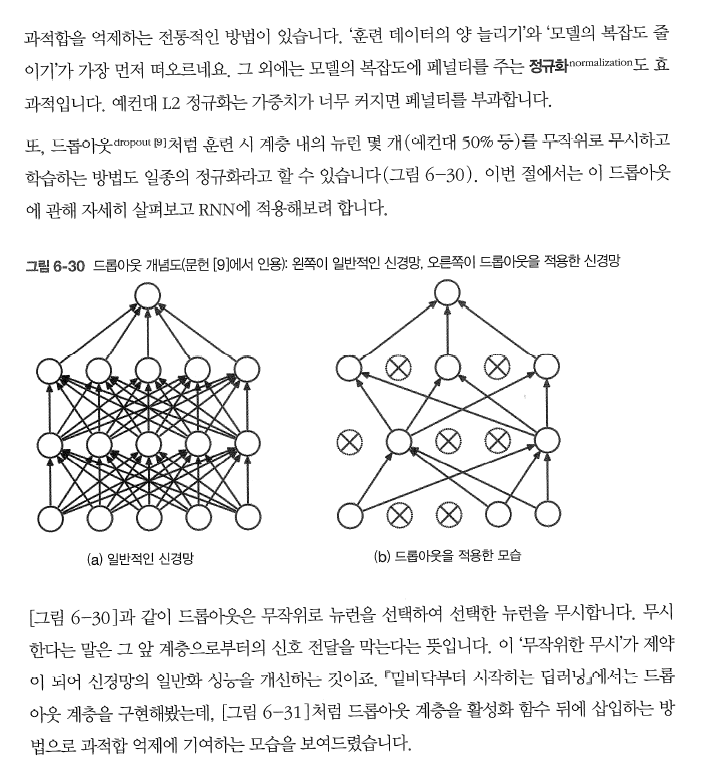

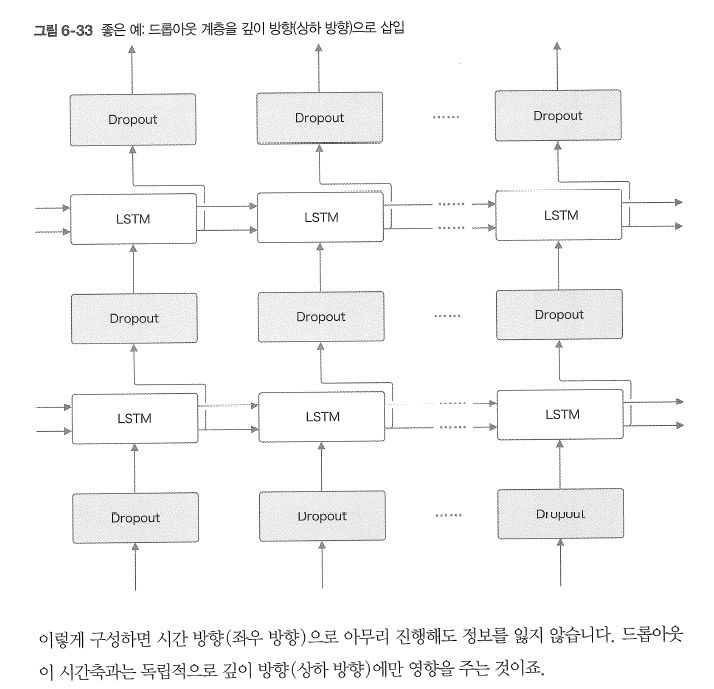

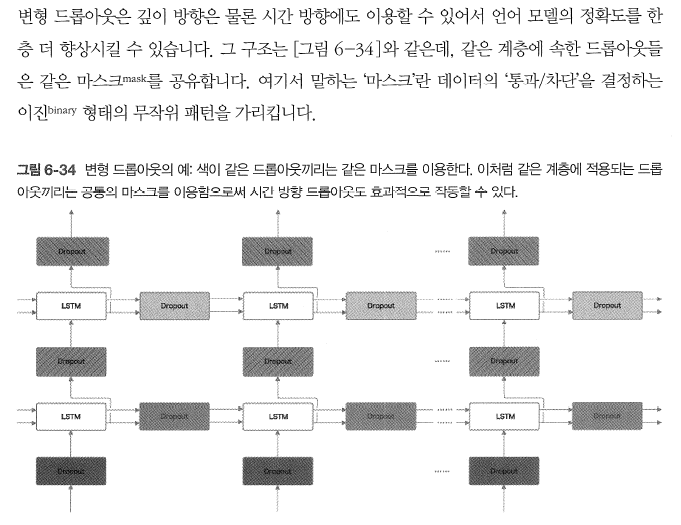

## 6.5.3 가중치 공유

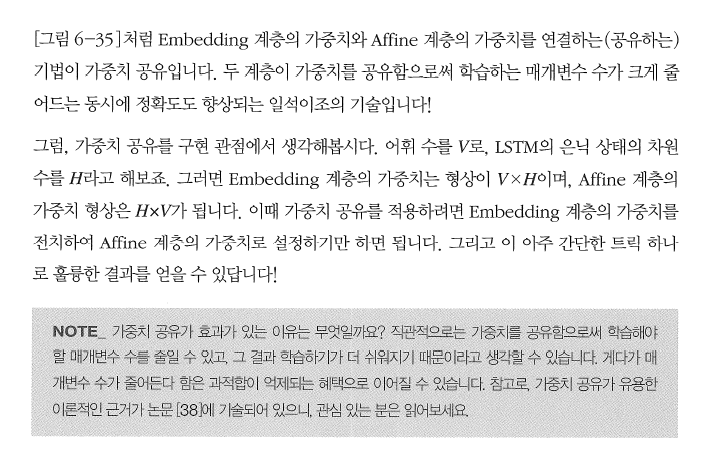

## 6.5.4 개선된 RNNLM 구현

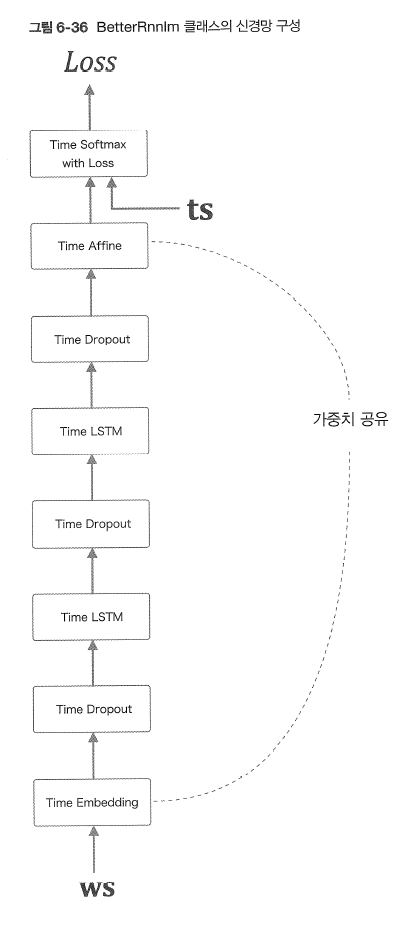

* LSTM 계층의 다층화(여기에서는 2층)
* 드롭아웃 사용( 깊이 방향으로만 적용)
* 가중치 공유(Embedding 계층과 Affine 계층에서 가중치 공유)

In [ ]:
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True), # LSTM1
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True), # LSTM2
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!! : 가중치 공유 - embed_W 전치
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

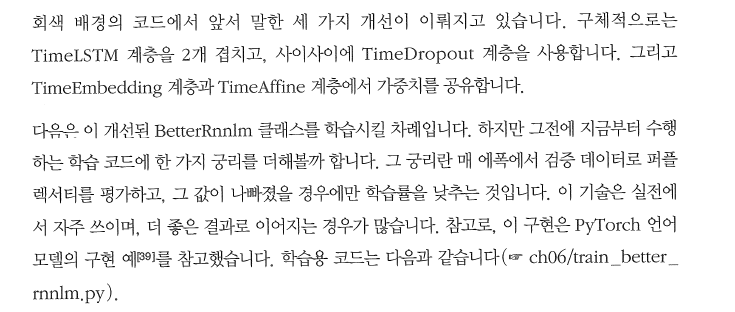

In [ ]:
from common import config
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

Done
| 에폭 1 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 9999.90
| 에폭 1 |  반복 21 / 1327 | 시간 76[s] | 퍼플렉서티 3862.94
| 에폭 1 |  반복 41 / 1327 | 시간 149[s] | 퍼플렉서티 2017.60
| 에폭 1 |  반복 61 / 1327 | 시간 221[s] | 퍼플렉서티 1307.18
| 에폭 1 |  반복 81 / 1327 | 시간 294[s] | 퍼플렉서티 1006.85
| 에폭 1 |  반복 101 / 1327 | 시간 366[s] | 퍼플렉서티 850.03
| 에폭 1 |  반복 121 / 1327 | 시간 438[s] | 퍼플렉서티 829.08
| 에폭 1 |  반복 141 / 1327 | 시간 510[s] | 퍼플렉서티 740.60
| 에폭 1 |  반복 161 / 1327 | 시간 582[s] | 퍼플렉서티 668.60
| 에폭 1 |  반복 181 / 1327 | 시간 654[s] | 퍼플렉서티 693.11
| 에폭 1 |  반복 201 / 1327 | 시간 726[s] | 퍼플렉서티 599.17
| 에폭 1 |  반복 221 / 1327 | 시간 797[s] | 퍼플렉서티 571.01
| 에폭 1 |  반복 241 / 1327 | 시간 870[s] | 퍼플렉서티 521.77
| 에폭 1 |  반복 261 / 1327 | 시간 942[s] | 퍼플렉서티 558.53
| 에폭 1 |  반복 281 / 1327 | 시간 1017[s] | 퍼플렉서티 526.31
| 에폭 1 |  반복 301 / 1327 | 시간 1089[s] | 퍼플렉서티 447.28
| 에폭 1 |  반복 321 / 1327 | 시간 1161[s] | 퍼플렉서티 396.15
| 에폭 1 |  반복 341 / 1327 | 시간 1233[s] | 퍼플렉서티 452.77
| 에폭 1 |  반복 361 / 1327 | 시간 1301[s] | 퍼플렉서티 470.67
| 에폭 1 |  반복 381 / 1327 |

* LSTM의 다층화 -> 표현력 증가
* DROPOUT -> 범용성 증가
* 가중치 공유 -> 정확도 향상

## 6.5.5 첨단 연구로

# 6.6 정리

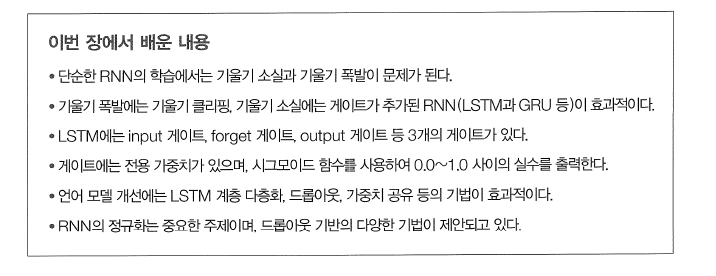